# Fit bmimpf6 data

EoS: SRK

Parameter T dependence: Linear in [R32, bmimpf6] direction

N (total fitting parameters): 3

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions_SRK import linear

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_full = pd.read_csv('r32_bmimpf6_full.csv')
# data_subset = pd.read_csv('r32_emimtf2n_subset.csv')

## Load Configuration + Check DOF

In [3]:
from hfc32_bmimpf6_SRK import configuration 

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

The initial DOF is 7


## Fit Parameters

In [6]:
parameters, obj_value, a = linear(data_full, configuration, 'R32', 'bmimpf6', "x_R32", "x_bmimpf6", 
    init_temp =  283.1, init_press =   399300 , init_x_c1 =    0.448, init_x_c2 = 0.552,
    init_kappa_2_1A = -0.001, init_kappa_1_2A = -0.001,
    init_kappa_2_1B = 0.0, init_kappa_1_2B = -0.001, eps = 0.1, scaling_fac = 1e-9,optional_params = 'Opt1')

2022-04-20 16:29:31 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 16:29:31 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 16:29:32 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 16:29:32 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 16:29:32 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 16:29:33 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 16:29:33 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 16:29:33 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-20 16:29:34 [INFO] idaes

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.0472518e-01 3.94e-02 9.31e-03  -3.8 4.91e+03    -  1.00e+00 1.00e+00h  1
  31  2.0402539e-01 2.69e-03 2.09e-03  -3.8 1.37e+03    -  1.00e+00 1.00e+00h  1
  32  2.0397449e-01 6.83e-04 2.39e-04  -5.7 4.51e+02    -  1.00e+00 1.00e+00h  1
  33  2.0397487e-01 7.69e-07 4.77e-07  -5.7 2.26e+01    -  1.00e+00 1.00e+00h  1
  34  2.0397487e-01 6.45e-08 2.98e-08  -8.6 4.10e+00    -  1.00e+00 1.00e+00h  1
  35  2.0397487e-01 4.81e-12 4.66e-10  -9.0 5.63e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   2.0397486692612843e-01    2.0397486692612843e-01
Dual infeasibility......:   4.6566128730773926e-10    4.6566128730773926e-10
Constraint violation....:   4.8148152131943789e-12    4.8148152131943789e-12
Complementarity.........:   9.0909210025726119e-10    9.0909210025726119e-10
Overall NLP error......

In [7]:
print('Objective (SSE):',obj_value)

Objective (SSE): 0.2039748669261284


In [8]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[ 0.00019434  0.00015802 -0.00017169]
 [ 0.00015802  0.0002358  -0.00013238]
 [-0.00017169 -0.00013238  0.00015257]]


In [9]:
np.savetxt('Data/Covariance/SRK_Cov_3parameter_ILHFCB0.csv',cov,delimiter=',')

## Apply Parameters + Plot

In [10]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [11]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.SRK_kappa_A['R32','bmimpf6'] = parameters['fs.properties.SRK_kappa_A[R32,bmimpf6]']
m.fs.properties.SRK_kappa_A['bmimpf6','R32'] = parameters['fs.properties.SRK_kappa_A[bmimpf6,R32]']
m.fs.properties.SRK_kappa_B['R32','bmimpf6'] = parameters['fs.properties.SRK_kappa_B[R32,bmimpf6]']
# m.fs.properties.PR_kappa_B['emimTf2N','R32'] = parameters['fs.properties.PR_kappa_B[emimTf2N,R32]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimpf6'].unfix()

R32_x = np.zeros((len(data_full)))
P = np.zeros((len(data_full)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimpf6"] == m.fs.liq)

for i in range(len(data_full)):
    m.fs.liq = data_full["x_bmimpf6"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_full["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_full["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'bmimpf6'].fix(float(1-(data_full["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    
#     DOF_final = degrees_of_freedom(m)
#     print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        print(data_full["x_bmimpf6"].iloc[i])
        R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

0.974
0.894
0.729
0.572
0.442
0.35
0.185
0.982
0.924
0.81
0.703
0.61
0.525
0.448
0.372
0.994
0.953
0.887
0.826
0.769
0.715
0.665
0.618
0.997
0.971
0.93
0.891
0.854
0.818
0.786
0.752


In [12]:
fitted_data = pd.DataFrame(data=[R32_x,P/1e6])
fitted_data = fitted_data.T
fitted_data.columns = ['R32_x','P, MPa']
fitted_data.to_csv('Data/Fits/SRK_FittedData_3parameter_ILHFCB0.csv')

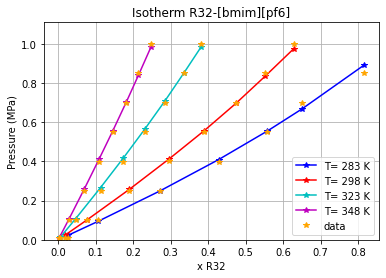

In [13]:
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

plt.plot(R32_x[0:7],P1[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P1[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P1[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:31],P1[23:31],"m-*",label="T= 348 K")
plt.plot(data_full["x_R32"],data_full["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R32-[bmim][pf6]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

### Print Eigvals, Eigvectors

An identifiability analysis can be performed with these as well as a FIM because the covariance matrix is the inverse of the FIM. That means that if there are any eigvals > 0, their eigvecs indicate directions of un-identifiability.

In [14]:
eigvals, eigvecs = np.linalg.eig(cov)

In [15]:
eigvals

array([5.04481038e-04, 2.18212791e-07, 7.80068218e-05])

In [16]:
eigvecs

array([[-0.59848485, -0.68429097, -0.41660742],
       [-0.60864166,  0.0502281 ,  0.79185382],
       [ 0.52093302, -0.72747715,  0.44654875]])

In [17]:
np.savetxt('Data/EigenAnalysis/SRK_vals_3parameter_ILHFCB0.csv',eigvals,delimiter=',')
np.savetxt('Data/EigenAnalysis/SRK_vecs_3parameter_ILHFCB0.csv',eigvecs,delimiter=',')

Conclusion: Fully identifiable because all eigvals ~ 0

## AIC Value

See https://docs.google.com/document/d/1um0r2XK4ldjjy2colOqaZsEM3wIzGD6l_3B8gnpnI2I/edit# for equations

In [18]:
n = 3

In [19]:
SSR = obj_value

In [20]:
sigma_sq = SSR/n
sigma_sq

0.06799162230870946

In [21]:
L = -n/2*np.log(2*np.pi) - n/2*np.log(sigma_sq) - 1/(2*sigma_sq)*SSR
L

-0.22425942550634814

In [22]:
AIC = 2*n - 2*L
AIC

6.448518851012697

In [23]:
AIC_data = pd.DataFrame(data=[n,obj_value,AIC])
AIC_data = AIC_data.T
AIC_data.columns = ['n','Objective, Pa^2','AIC']
AIC_data.to_csv('Data/AIC/SRK_AIC_3parameter_ILHFCB0.csv')